<a href="https://colab.research.google.com/github/springboardmentor2501/Shipment-Sure/blob/Almeehra-Shaikh/milestone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
df = pd.read_csv("/smart_logistics_dataset.csv")


Shape: (1000, 16)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best F1-macro score: 0.8325
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 400, 'clf__num_leaves': 31}

========== Hold-out results ==========
Accuracy : 0.8623
Precision: 0.8451
Recall   : 0.8824
F1-Score : 0.8633
ROC-AUC  : 0.9519

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        70
           1       0.85      0.88      0.86        68

    accuracy                           0.86       138
   macro avg       0.86      0.86      0.86       138
weighted avg       0.86      0.86      0.86       138



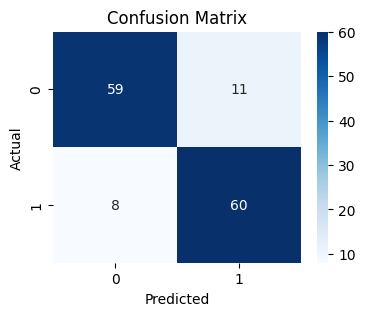

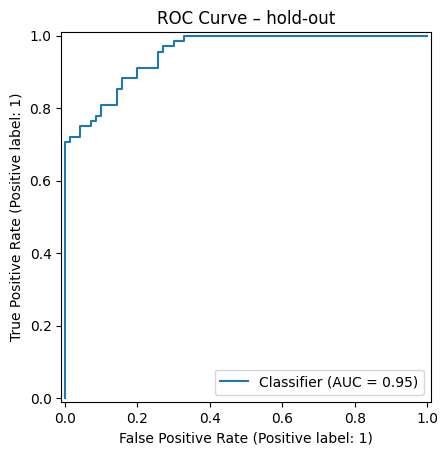

In [ ]:

# 1. Imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             classification_report, RocCurveDisplay)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline   # keeps sampling inside CV

import lightgbm as lgb
import joblib, warnings, os, datetime
warnings.filterwarnings("ignore")

# ------------------------------------------------------------
# 2. Load data
# ------------------------------------------------------------
PATH = "/content/smart_logistics_dataset.csv"
df = pd.read_csv(PATH, parse_dates=["Timestamp"])
print("Shape:", df.shape)
df.head()

# ------------------------------------------------------------
# 3. Basic cleaning & derived features
# ------------------------------------------------------------
# 3a. Map only finished shipments
df = df[df.Shipment_Status.isin(["Delivered", "Delayed"])]   # drop "In Transit"
target_map = {"Delivered": 1, "Delayed": 0}
df["Target"] = df.Shipment_Status.map(target_map)
y = df["Target"]
assert y.isna().sum() == 0, "Unmapped shipment status found"

# 3b. Cyclical time features
def add_cyclical(df, col, max_val):
    df[f"{col}_sin"] = np.sin(2 * np.pi * df[col]/max_val)
    df[f"{col}_cos"] = np.cos(2 * np.pi * df[col]/max_val)
    return df

df["month"]  = df.Timestamp.dt.month
df["day"]    = df.Timestamp.dt.day
df["weekday"]= df.Timestamp.dt.weekday
df["hour"]   = df.Timestamp.dt.hour

df = add_cyclical(df, "month", 12)
df = add_cyclical(df, "day", 31)
df = add_cyclical(df, "weekday", 7)
df = add_cyclical(df, "hour", 24)

# 3c. Risk flags
df["risk_high_traffic"] = (df.Traffic_Status == "High").astype(int)
df["risk_delay_reason"] = df.Logistics_Delay_Reason.notna().astype(int)
df["risk_temp"] = ((df.Temperature < 5) | (df.Temperature > 35)).astype(int)
df["risk_humidity"] = (df.Humidity > 85).astype(int)

# 3d. Interactions
df["lat_x_long"] = df.Latitude * df.Longitude
df["util_demand"] = df.Asset_Utilization * df.Demand_Forecast
df["inv_wait"] = df.Inventory_Level * df.Waiting_Time

# 3e. Drop original high-cardinality or redundant columns
drop_cols = ["Timestamp", "Shipment_Status", "Asset_ID"]
X = df.drop(columns=drop_cols+["Target"])

# ------------------------------------------------------------
# 4. Pre-processing blueprint
# ------------------------------------------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = ["Traffic_Status", "Logistics_Delay_Reason"]

numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ]
)

# ------------------------------------------------------------
# 5. Model & hyper-parameter grid
# ------------------------------------------------------------
lgbm = lgb.LGBMClassifier(
    objective="binary",
    class_weight="balanced",   # handle imbalance
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

param_grid = {
    "clf__n_estimators": [400],
    "clf__learning_rate": [0.1],
    "clf__max_depth": [6],
    "clf__num_leaves": [31]
}

# ------------------------------------------------------------
# 6. Train / test split
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

# ------------------------------------------------------------
# 7. Build full pipeline with SMOTE inside CV
# ------------------------------------------------------------
pipe = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("clf", lgbm)
])

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="f1_macro",      # optimise for high F1
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Best F1-macro score: {:.4f}".format(grid.best_score_))
print("Best params:", grid.best_params_)

# ------------------------------------------------------------
# 8. Evaluation on hold-out set
# ------------------------------------------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
roc  = roc_auc_score(y_test, y_prob)

print("\n========== Hold-out results ==========")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual"); plt.xlabel("Predicted")
plt.show()

RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve – hold-out")
plt.show()

